In [1]:
import chainer
from PIL import Image, ImageDraw, ImageFont, ImageOps
import csv
import cv2
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
# pyclustering with custom distance metric
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.utils.metric import type_metric, distance_metric
import imutils
import easyocr
from manga_ocr import MangaOcr
from scipy.ndimage import rotate
from imutils.contours import sort_contours

import sys
sys.path.append('../../')

from kr.detector.centernet.resnet import Res18UnetCenterNet
from kr.classifier.softmax.mobilenetv3 import MobileNetV3
from kr.datasets import KuzushijiUnicodeMapping

/home/ec2-user/code/restor-ai-tion/data/full/200021763/images/200021763_00016_1.jpg
(2763, 4408)


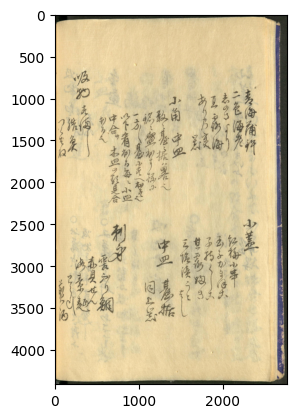

In [2]:
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'
filename = '/home/ec2-user/code/restor-ai-tion/data/full/200021763/images/200021763_00016_1.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/brsk00000/images/brsk001_005.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200014685/images/200014685_00002_2.jpg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200004148/images/200004148_00002_2.jpg'
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/image2.png'
# inverted_filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/invertedimage2.png'
# image = Image.open(filename)
# inverted_image = ImageOps.invert(image)
# inverted_image.save(inverted_filename)
# filename = inverted_filename
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/e6eeb23552e1a21c.png'
print(filename)
image = Image.open(filename)
# img1 = image.resize((640, 640))
# img1.save('/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/t.png')
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/t.png'
plt.imshow(image, cmap='gray')
print(image.size)
plt.show()



In [3]:
def predict(detector_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/detector/model_700.npz',
            classifier_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/classifier/model_1000.npz',
            image_filename='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new-images/example.jpg'):

    # unicode <-> unicode index mapping
    mapping = KuzushijiUnicodeMapping()
    
    # load trained detector
    detector = Res18UnetCenterNet()
    chainer.serializers.load_npz(detector_model, detector)
    
    # load trained classifier
    classifier = MobileNetV3(out_ch=len(mapping))
    chainer.serializers.load_npz(classifier_model, classifier)
    
    # load image
    image = Image.open(image_filename)
    
    # character detection
    bboxes, bbox_scores = detector.detect(image)
    
    # character classification
    unicode_indices, scores = classifier.classify(image, bboxes)
    unicodes = [mapping.index_to_unicode(idx) for idx in unicode_indices]
    return unicodes, scores, bboxes, bbox_scores

In [4]:
unicodes, unicode_scores, bboxes, bbox_scores = predict(image_filename=filename)
for uc, bb in zip(unicodes, bboxes):
    label = chr(int(uc[2:], 16))
    print(uc, label, bb)

U+8C9D 貝 [ 394.80764403 3044.74339215  488.69771711 3207.28011631]
U+304B か [1932.93604157 2933.07716693 2034.45340703 3025.30722927]
U+6D77 海 [2258.47682269 1101.07238683 2403.27438327 1248.59166359]
U+307B ほ [1928.12804984 3145.49635048 2050.05609751 3271.17313698]
U+6F2C 漬 [1504.01820778 2991.85044061 1611.60913282 3145.69466226]
U+985E 類 [ 659.08348693 1908.81042221  761.4761925  2031.6903512 ]
U+3053 こ [1937.09843441 3275.57588636 2058.1411847  3395.5336642 ]
U+8D64 赤 [ 390.49027617 2883.88736469  500.10399607 3042.1862007 ]
U+6D77 海 [2118.79960807 1260.46673955 2249.08542646 1415.91957977]
U+4E8C 二 [2108.74024434  917.42843986 2204.80388381 1003.17356954]
U+6D77 海 [ 243.02755977 2899.41277897  360.0334868  3077.23478875]
U+5B50 子 [1785.51538426 2653.85228853 1866.35346198 2786.55937337]
U+8272 色 [2119.2771642  1040.39968166 2220.75216694 1204.52978563]
U+51FA 出 [ 788.86133383 1604.31397246  893.20799483 1719.67366856]
U+307E ま [ 278.14978908 1219.18091079  426.31791011 1402.31651

In [5]:
font_path = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/font/NotoSansCJKjp-Regular.otf'
font = ImageFont.truetype(font_path, 50, encoding='utf-8')
text_color = 'rgb(255, 0, 0)'
true_color = 'rgb(0, 0, 255)'

def bbox_values(bbox):
    divisor = 1
    return int(bbox[0]/divisor), int(bbox[1]/divisor), int(bbox[2]/divisor), int(bbox[3]/divisor)

def visualize_preds(orig_filename, unicodes, unicode_scores, bboxes, bbox_scores, 
                    limit=-1,
                    verbose=False,
                    full_dataset='/home/ec2-user/code/restor-ai-tion/data/full',
                    same_image=True,
                    save_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    orig_img = Image.open(orig_filename)
    pred_img = Image.open(orig_filename)
    true_img = Image.open(orig_filename)
    pred_draw = ImageDraw.Draw(pred_img)
    true_draw = ImageDraw.Draw(true_img)
    if limit == -1:
        limit = len(unicodes)
    print('limit', limit)

    for (pred, uscore, bbox, bscore) in zip(unicodes[:limit], unicode_scores[:limit], bboxes[:limit], bbox_scores[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        if verbose:
            print('!!!', pred, label, uscore, x, y, w, h, bscore)

        
        pred_draw.text((x - 50, y - 10), label, fill=text_color, font = font)
        # pred_draw.rectangle([(x, y), (w, h)], outline='blue', width=3)


    x = os.path.basename(orig_filename).replace('-', '_')
    true_image_available = False

    num_correct = 0
    num_wrong = 0

    print(x)
    
    if len(x.split('_')) >= 2:
        true_image_available = True
        bookname = x.split('_')[0]
        if bookname.startswith('umgy'):
            bookname = 'umgy00000'
        elif bookname.startswith('hnsd'):
            bookanme = 'hnsd00000'
        elif bookname.startswith('brsk'):
            bookname = 'brsk00000'

        image_name = x.split('.')[0]
        csv_file = os.path.join(full_dataset, bookname, '{}_coordinate.csv'.format(bookname))
        print(csv_file)
        true_unicodes = []
        true_bboxes = []
        with open(csv_file) as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Image'] == image_name:
                    uc = row['Unicode']
                    true_unicodes.append(chr(int(uc[2:], 16)))
                    true_bboxes.append([int(row['X']), int(row['Y']), int(row['Width']), int(row['Height'])])

        print(len(true_unicodes), len(unicodes))
        total = len(true_unicodes)

        if same_image:
            dimg = pred_draw
        else:
            dimg = true_draw
        for (uc, bbox) in zip(true_unicodes, true_bboxes):
            x, y, w, h = bbox_values(bbox)
            w = w + x
            h = h + y
            if verbose:
                print('>', pred, label, uscore, x, y, w, h, bscore)
    
            
            dimg.text((x + 100, y - 10), uc, fill=true_color, font = font)
            # dimg.rectangle([(x, y), (w, h)], outline='green', width=4)  
            found_char = False
            for (pred, pbbox) in zip(unicodes[:limit], bboxes[:limit]):
                # if abs(xpred - x) < 200.0 and abs(ypred - y) < 200.0 and cpred == char:
                xpred, ypred, width, height = bbox_values(pbbox)
                puc = chr(int(pred[2:], 16))
                if abs(xpred - x) < 200 and abs(ypred - y) < 200 and puc == uc:
                    found_char = True
                    break
            if found_char:
                num_correct += 1
            else:
                num_wrong += 1

        print('accuracy', total, (num_correct*1.0/total), (num_wrong*1.0)/total)

    if same_image or not true_image_available:
        plt.figure()
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        basename = os.path.basename(orig_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_filename]
    else:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(true_img)
        plt.title('True')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pred_img)
        plt.title('Predicted')
        plt.axis('off')

        
        basename = os.path.basename(orig_filename)
        save_true_filename = os.path.join(save_folder, 'true_{}'.format(basename))
        true_img.save(save_true_filename)
        save_filename = os.path.join(save_folder, 'pred_{}'.format(basename))
        pred_img.save(save_filename)
        viz_filenames = [save_true_filename, save_filename]

    return viz_filenames


limit 130
200021763_00016_1.jpg
/home/ec2-user/code/restor-ai-tion/data/full/200021763/200021763_coordinate.csv
135 130
accuracy 135 0.8518518518518519 0.14814814814814814


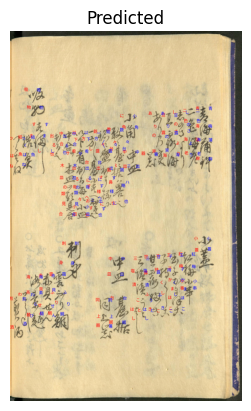

In [6]:
pred_filenames = visualize_preds(filename,
                                 unicodes, unicode_scores, bboxes, bbox_scores, 
                                 same_image=True,
                                 limit=-1, verbose=False)
pred_filename = pred_filenames[0]

In [7]:
# clustering of bounding boxes
clustering_data = []
for uc, box in zip(unicodes, bboxes):
    x, y, w, h = box
    clustering_data.append([x, y, uc])
clustering_df = pd.DataFrame(clustering_data, columns=['X', 'Y', 'Char'])
clustering_df

,X,Y,Char
0,394.807644,3044.743392,U+8C9D
1,1932.936042,2933.077167,U+304B
2,2258.476823,1101.072387,U+6D77
3,1928.128050,3145.496350,U+307B
4,1504.018208,2991.850441,U+6F2C
...,...,...,...
125,1133.260872,1322.375707,U+3005
126,987.125825,1372.985510,U+3057
127,1550.243637,3175.866661,U+3053
128,713.678230,1426.302994,U+30B5


In [8]:
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])

def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im
    
def blob_detection(image_filename):
    sample = imread(image_filename)
    sample_g = rgb2gray(sample)
    sample_b = sample_g > 0.6
    sample_dil = multi_dil(sample_b, 7)
    # sample_closed = area_closing(sample_dil, 50000)
    # sample_eroded = multi_ero(sample_closed, 7)
    # sample_opened = opening(sample_eroded)
    # final_image = sample_opened
    # sample_eroded = multi_ero(sample_dil, 7)
    final_image = sample_dil
    plt.imshow(final_image)
    label_im = label(final_image)
    regions = regionprops(label_im)
    plt.imshow(label_im)
    print(regions)

    # masks = []
    # bbox = []
    # list_of_index = []
    # for num, x in enumerate(regions):
    #     area = x.area
    #     convex_area = x.convex_area
    #     if (num!=0 and (area>100) and (convex_area/area <1.05)
    #     and (convex_area/area >0.95)):
    #         masks.append(regions[num].convex_image)
    #         bbox.append(regions[num].bbox)   
    #         list_of_index.append(num)
    # count = len(masks)

    # print(count)

    # fig, ax = plt.subplots(2, int(count/2), figsize=(15,8))
    # for axis, box, mask in zip(ax.flatten(), bbox, masks):
    #     red  =  painting[:,:,0][box[0]:box[2], box[1]:box[3]] * mask
    #     green = painting[:,:,1][box[0]:box[2], box[1]:box[3]] * mask
    #     blue  = painting[:,:,2][box[0]:box[2], box[1]:box[3]] * mask
    #     image = np.dstack([red,green,blue])
    #     axis.imshow(image)

    # rgb_mask = np.zeros_like(label_im)
    # for x in list_of_index:
    #     rgb_mask += (label_im==x+1).astype(int)
    # red  =  painting[:,:,0] * rgb_mask
    # green = painting[:,:,1] * rgb_mask
    # blue  = painting[:,:,2] * rgb_mask
    # image = np.dstack([red, green, blue])
    # imshow(image)

[<skimage.measure._regionprops.RegionProperties object at 0x7f7f83fafd00>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83fafac0>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83fac2e0>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83fafca0>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83fafd90>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83face20>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83facd90>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83facf40>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83facf10>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83fafdc0>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83faea10>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83fae830>, <skimage.measure._regionprops.RegionProperties object at 0x7f7f83fac2b0>, <skimage.measure._regionprops.RegionP

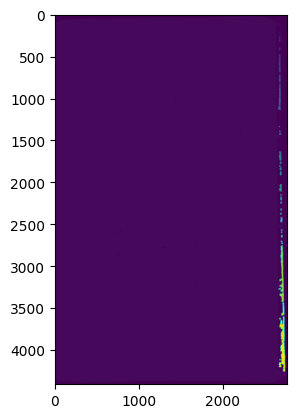

In [9]:
blob_detection('/home/ec2-user/code/restor-ai-tion/data/full/200021763/images/200021763_00016_1.jpg')

In [10]:
def py_row_clusters(data, imx, imy, n_clusters=4):
    bx = list(data['X'])
    by = list(data['Y'])
    bxy = list(zip(bx,by))

    user_function = lambda point1, point2: (abs(point1[1] - point2[1])) ** 10 + (abs(point1[0] - point2[0])) ** 1
    metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
    
    # create K-Means algorithm with specific distance metric
    start_centers = []
    column_size = imx / n_clusters
    offset = column_size/2
    for cid in range(n_clusters):
        start_centers.append([offset+(cid*column_size), imy/2])
    print(start_centers)
    kmeans_instance = kmeans(bxy, start_centers, metric=metric)
    
    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()

    cluster_fig = kmeans_visualizer.show_clusters(bxy, kmeans_instance.get_clusters(), kmeans_instance.get_centers())
    cluster_fig.savefig('data/preds/clusters_{}'.format(os.path.basename(filename)))
    cluster_fig.show()


    return kmeans_instance

[[345.375, 2204.0], [1036.125, 2204.0], [1726.875, 2204.0], [2417.625, 2204.0]]


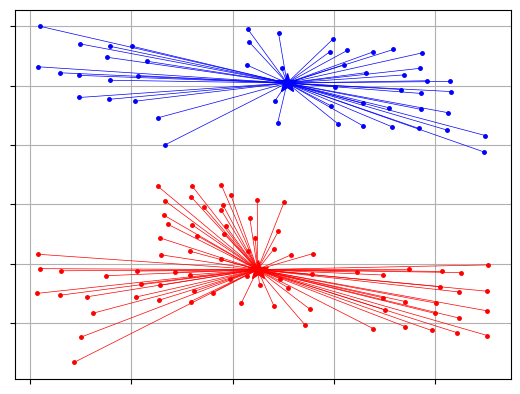

In [11]:
py_row_clusters(clustering_df, image.size[0], image.size[1], n_clusters=4)

In [12]:
def py_column_clusters(data, imx, imy, n_clusters=8):
    bx = list(data['X'])
    by = list(data['Y'])
    bxy = list(zip(bx,by))

    user_function = lambda point1, point2: abs(point1[1] - point2[1]) + abs(point1[0] - point2[0]) ** 2
    metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
    
    # create K-Means algorithm with specific distance metric
    start_centers = []
    column_size = imx / n_clusters
    offset = column_size/2
    for cid in range(n_clusters):
        start_centers.append([offset+(cid*column_size), imy/2])
    print(start_centers)
    kmeans_instance = kmeans(bxy, start_centers, metric=metric)
    
    # run cluster analysis and obtain results
    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()

    cluster_fig = kmeans_visualizer.show_clusters(bxy, kmeans_instance.get_clusters(), kmeans_instance.get_centers())
    cluster_fig.savefig('data/preds/clusters_{}'.format(os.path.basename(filename)))
    cluster_fig.show()


    return kmeans_instance

[[69.075, 2204.0], [207.22500000000002, 2204.0], [345.375, 2204.0], [483.52500000000003, 2204.0], [621.6750000000001, 2204.0], [759.825, 2204.0], [897.9750000000001, 2204.0], [1036.125, 2204.0], [1174.275, 2204.0], [1312.4250000000002, 2204.0], [1450.575, 2204.0], [1588.7250000000001, 2204.0], [1726.8750000000002, 2204.0], [1865.025, 2204.0], [2003.1750000000002, 2204.0], [2141.325, 2204.0], [2279.475, 2204.0], [2417.625, 2204.0], [2555.775, 2204.0], [2693.9249999999997, 2204.0]]


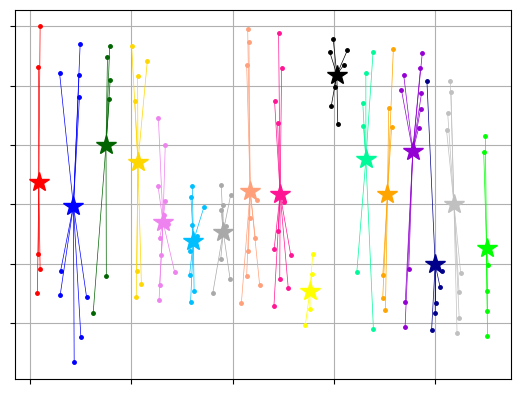

In [13]:
k = py_column_clusters(clustering_df, image.size[0], image.size[1], n_clusters=20)

In [14]:
clusters = k.get_clusters()
reading_order_list = []
n = len(clusters)

for _ in range(n):
    reading_order_list.append([])

print(len(reading_order_list), n)

for cid in range(n):
    pts = [[clustering_df['X'][row], clustering_df['Y'][row], clustering_df['Char'][row]] for row in clusters[cid]]
    s_pts = sorted(pts, key=lambda pt: pt[1])
    reading_order_list[n-1-cid] = s_pts

phrase = []
for col in reading_order_list:
    for c in col:
        x = c[2]
        phrase.append(chr(int(x[2:], 16)))
' '.join(phrase)

17 17


'青 海 蒲 鉾 小 蓋 二 色 海 老 紅 梅 小 事 し の さ よ り ま 豆 露 海 玉 子 か く し ほ こ り の 実 子 持 こ あ 器 世 露 ふ き 三 塩 漬 こ は と し に 角 中 皿 教 々 台 〻 据 鼻 也 中 皿 台 据 銘 々 盛 出 す 様 に 同 上 器 方 し 台 に す へ お す 也 以 下 肴 出 る 毎 々 小 皿 中 合 サ 木 皿 の 類 見 合 刺 身 出 る 也 霊 ふ り 鯛 す し 赤 貝 せ ん 吸 物 ま 結 魚 海 茶 わ 麺 つ は ね 煎 酒'

In [15]:
def get_true_phrase(filename, full_dataset='/home/ec2-user/code/restor-ai-tion/data/full'):
    x = os.path.basename(filename).replace('-', '_')
    true_image_available = False

    num_correct = 0
    num_wrong = 0

    # print(x)
    
    if len(x.split('_')) >= 2:
        true_image_available = True
        bookname = x.split('_')[0]
        if bookname.startswith('umgy'):
            bookname = 'umgy00000'
        elif bookname.startswith('hnsd'):
            bookname = 'hnsd00000'
        elif bookname.startswith('brsk'):
            bookname = 'brsk00000'

    image_name = x.split('.')[0]
    csv_file = os.path.join(full_dataset, bookname, '{}_coordinate.csv'.format(bookname))
    # print(csv_file)
    true_unicodes = []
    with open(csv_file) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['Image'] == image_name:
                uc = row['Unicode']
                char_id = row['Char ID']
                true_unicodes.append([chr(int(uc[2:], 16)), char_id])

    true_phrase = [x[0] for x in true_unicodes]
    return true_phrase

In [16]:
true_phrase = get_true_phrase(filename)
print('true', ' '.join(true_phrase))
print('pred', ' '.join(phrase))

print(len(true_phrase), len(phrase))

true 青 梅 蒲 鉾 二 色 海 老 し の さ よ り 豆 露 海 あ り の 実 箸 小 角 中 皿 数 々 台 ニ 据 ハ 略 也 銘 々 盛 出 す 様 に 一 方 〱 台 に す へ 出 す 也 以 下 肴 出 る 毎 ニ 小 皿 中 合 サ 木 皿 の 類 見 合 出 る 也 吸 物 す ま し 結 魚 つ く は ね 小 蓋 紅 梅 小 串 玉 子 か ま ほ こ 子 持 く し こ 甘 露 ふ き 三 塩 漬 う と は し 中 皿 台 据 同 上 箸 刺 身 霜 ふ り 鯛 赤 貝 せ ん 海 素 麺 わ ら び 煎 酒
pred 青 海 蒲 鉾 小 蓋 二 色 海 老 紅 梅 小 事 し の さ よ り ま 豆 露 海 玉 子 か く し ほ こ り の 実 子 持 こ あ 器 世 露 ふ き 三 塩 漬 こ は と し に 角 中 皿 教 々 台 〻 据 鼻 也 中 皿 台 据 銘 々 盛 出 す 様 に 同 上 器 方 し 台 に す へ お す 也 以 下 肴 出 る 毎 々 小 皿 中 合 サ 木 皿 の 類 見 合 刺 身 出 る 也 霊 ふ り 鯛 す し 赤 貝 せ ん 吸 物 ま 結 魚 海 茶 わ 麺 つ は ね 煎 酒
135 130


In [17]:
k.get_centers()

[[42.40838400197144, 2188.1488120106665],
 [213.19672993011775, 1986.9229821889057],
 [374.3460809352736, 2496.228068114781],
 [532.221407312859, 2353.1331159193132],
 [655.8604661546831, 1851.7843367722378],
 [806.0705319909522, 1689.2351651179597],
 [953.642155737258, 1768.4224566744595],
 [1086.6565879858458, 2113.9269852831594],
 [1234.7931772415768, 2085.1224252123657],
 [1382.0713100111327, 1272.0644488527282],
 [1514.836301861638, 3092.5778504279847],
 [1658.4129247088702, 2379.902161153594],
 [1764.8870241230068, 2082.541323535205],
 [1889.9124935929308, 2444.9512890792475],
 [2000.748710896032, 1493.6584978591864],
 [2093.4267097620404, 2003.0162561947434],
 [2254.6011925828284, 1628.2797161286198]]

In [18]:
' '.join([chr(int(c[2:], 16)) for c in unicodes])

'貝 か 海 ほ 漬 類 こ 赤 海 二 海 子 色 出 ま 毎 ふ 皿 小 上 あ 蒲 持 に さ す 玉 せ 紅 蓋 小 鯛 物 お 青 老 銘 子 中 鉾 き 肴 皿 へ 塩 同 出 台 ね 教 身 る 霊 の 器 中 豆 露 梅 刺 魚 事 角 よ 合 方 皿 見 様 也 し す の 結 皿 露 小 台 下 也 に 出 ま り 吸 盛 海 茶 台 器 こ 也 木 は 三 据 く 麺 合 つ と 酒 ふ 世 据 し 鼻 以 中 に る は わ り 実 す り の す し ん 々 し 〻 々 々 し こ サ 煎'

In [19]:
def get_text(chars, boxes, limit=-1):
    if limit == -1:
        limit = len(chars)

    ubox_tuples = [(chr(int(c[2:], 16)), bbox_values(box)) for (c, box) in zip(chars[:limit], boxes[:limit])]
    print(ubox_tuples)

In [20]:
get_text(unicodes, bboxes, limit=10)

[('貝', (394, 3044, 488, 3207)), ('か', (1932, 2933, 2034, 3025)), ('海', (2258, 1101, 2403, 1248)), ('ほ', (1928, 3145, 2050, 3271)), ('漬', (1504, 2991, 1611, 3145)), ('類', (659, 1908, 761, 2031)), ('こ', (1937, 3275, 2058, 3395)), ('赤', (390, 2883, 500, 3042)), ('海', (2118, 1260, 2249, 1415)), ('二', (2108, 917, 2204, 1003))]


In [21]:
int_boxes = np.array([bbox_values(b) for b in bboxes[:10]])
print(int_boxes)

[[ 394 3044  488 3207]
 [1932 2933 2034 3025]
 [2258 1101 2403 1248]
 [1928 3145 2050 3271]
 [1504 2991 1611 3145]
 [ 659 1908  761 2031]
 [1937 3275 2058 3395]
 [ 390 2883  500 3042]
 [2118 1260 2249 1415]
 [2108  917 2204 1003]]


In [22]:
def bbox_values2(bbox):
    divisor = 1
    b = bbox/divisor
    return int(b[0]), int(b[1]), int(abs(b[0]-b[2])), int(abs(b[1]-b[3]))

def get_unicode(uc):
    return [chr(int(c[2:],16)) for c in uc]

scaled_bboxes = [bbox_values2(b) for b in bboxes]



print(scaled_bboxes[:10])
print(' '.join(get_unicode(unicodes)))


# uc = [chr(int(c[2:], 16)) for c in unicodes]
# tb = list(zip(*sorted(zip(uc, scaled_bboxes), key=lambda b: -b[1][0]+b[1][1], reverse=False)))
# print(' '.join(list(tb)[0]))
# for i in range(10):
#     print(tb[0][i], tb[1][i])
# # rl = list(zip(*sorted(zip(*tb), key=lambda b: b[1][1], reverse=False)))
# # print(' '.join(list(rl)[0]))
# # print(rl[0][0], tb[1][0])
# # print(rl[0][1], rl[1][1])

# arr = np.array(bboxes)
# r = (arr[:, 0]**2 + arr[:, 1] **2)**0.5
# indices = np.argsort(r)
# print(indices)
# ordered_chars = []
# for i in indices:
#     c = unicodes[i]
#     ordered_chars.append(chr(int(c[2:], 16)))
# print(ordered_chars)



[(394, 3044, 93, 162), (1932, 2933, 101, 92), (2258, 1101, 144, 147), (1928, 3145, 121, 125), (1504, 2991, 107, 153), (659, 1908, 102, 122), (1937, 3275, 121, 119), (390, 2883, 109, 158), (2118, 1260, 130, 155), (2108, 917, 96, 85)]
貝 か 海 ほ 漬 類 こ 赤 海 二 海 子 色 出 ま 毎 ふ 皿 小 上 あ 蒲 持 に さ す 玉 せ 紅 蓋 小 鯛 物 お 青 老 銘 子 中 鉾 き 肴 皿 へ 塩 同 出 台 ね 教 身 る 霊 の 器 中 豆 露 梅 刺 魚 事 角 よ 合 方 皿 見 様 也 し す の 結 皿 露 小 台 下 也 に 出 ま り 吸 盛 海 茶 台 器 こ 也 木 は 三 据 く 麺 合 つ と 酒 ふ 世 据 し 鼻 以 中 に る は わ り 実 す り の す し ん 々 し 〻 々 々 し こ サ 煎


In [23]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(img, [5, 5], 0)
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts[:2]
# cv2.boundingRect(cnts[0])
# cnts = imutils.contours.sort_contours(cnts, method='left-to-right')[0]
# print(cnts[:1])

(array([[[  44, 4397]],
 
        [[  43, 4398]],
 
        [[  39, 4398]],
 
        [[  38, 4399]],
 
        [[  37, 4399]],
 
        [[  37, 4400]],
 
        [[  38, 4400]],
 
        [[  40, 4398]],
 
        [[  43, 4398]],
 
        [[  44, 4397]],
 
        [[  46, 4399]],
 
        [[  47, 4399]],
 
        [[  48, 4400]],
 
        [[  48, 4401]],
 
        [[  49, 4402]],
 
        [[  49, 4403]],
 
        [[  50, 4404]],
 
        [[  49, 4405]],
 
        [[  49, 4407]],
 
        [[  49, 4405]],
 
        [[  50, 4404]],
 
        [[  49, 4403]],
 
        [[  49, 4401]],
 
        [[  46, 4398]],
 
        [[  45, 4398]]], dtype=int32),
 array([[[2136, 4393]],
 
        [[2135, 4394]],
 
        [[2135, 4396]],
 
        [[2136, 4397]],
 
        [[2140, 4397]],
 
        [[2140, 4396]],
 
        [[2141, 4395]],
 
        [[2140, 4394]],
 
        [[2140, 4393]]], dtype=int32))

In [24]:
def ocr_image(tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds',
                    image_filename=filename):
    # new image attempt.
    tgt_filename = os.path.join(tgt_folder, 'ocr_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))
    pred_draw = ImageDraw.Draw(pred_image)
    limit = len(unicodes)
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_draw.text((x-20, y-10), label, fill=text_color, font = font)
    pred_image.save(tgt_filename)    
    
    ocr_img = cv2.imread(tgt_filename)
    plt.imshow(ocr_img)
    return tgt_filename

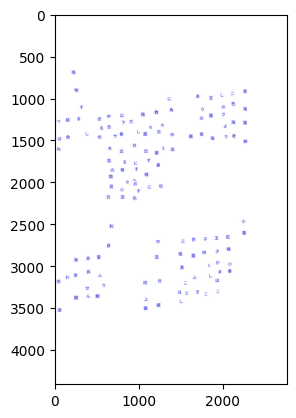

In [25]:
ocr_filename = ocr_image(image_filename=filename)

In [26]:
def easyocr_prediction(ocr_filename, detail=0):
    ## easyocr on modern japenese
    reader = easyocr.Reader(['ja'])
    result = reader.readtext(ocr_filename, detail = detail)
    return result

In [27]:
result = easyocr_prediction(pred_filename, detail=0)
' '.join(result)

'吸 吸 物 物 喜 青 に あ } 駐元 八小 刀 すあ す 典 以銘一 諸 ブ 角 の 文戸 の . 一樹 ま 出 合 方下 方 〈 磯 \'乃% よ 海ばほ (ば る る は 魚は魚 也く 町 盛 ・鶴才 とえこ 海 岡 鉾 ね ね 益 着 急  掛 く 皿 皿 す 興る三 筑 様 装 路 々 縁 多 也 具見 7 合 倒 り廻 也 刺 身 刺 三 当 晋 ( 慧 身 中 ろ 梅 ! 霜 麓 拝く 海め 毒 霧 迎 "峻 漬 漬 務 かわ 串 わ: 鷺 お ふ ま} 事奉 苅 藤 同 ほ ほ り り ころ # せ 唐 はたとは こ 熱 [ /ん{期 上ふ し 酒 器 曹 掘 酒 昌 8 中出 香 角 智 中器 老り}} 差 台 3 角 # ~ 多 織 茶わ @ らせ 芝たき'

In [28]:
# manga-ocr
def mangaocr_prediction(tgt_filename):
    mocr = MangaOcr()
    text = mocr(tgt_filename)
    return text

In [29]:
text = mangaocr_prediction(pred_filename)
print(text)

2023-10-31 01:26:50.797 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
2023-10-31 01:26:51.217370: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 01:26:51.217420: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 01:26:51.217441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 01:26:51.224627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other opera

あ、そうだなぁ．．．


In [30]:
# new image (rotated) attempt.
def rot(dim_orig, dim_rot, xy, angle=90):
    org_center = (np.array(dim_orig[:2][::-1])-1)/2.
    rot_center = (np.array(dim_rot[:2][::-1])-1)/2.
    org = xy-org_center
    a = np.deg2rad(angle)
    new = np.array([org[0]*np.cos(a) + org[1]*np.sin(a),
            -org[0]*np.sin(a) + org[1]*np.cos(a) ])
    return new+rot_center

def rotate_image(image_filename, ocr_filename, tgt_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
    tgt_rot_filename = os.path.join(tgt_folder, 'ocr_rotated_{}'.format(os.path.basename(image_filename)))
    cv2img = cv2.imread(image_filename)
    n, m = cv2img.shape[0], cv2img.shape[1]
    pred_rot_image = Image.new('RGB', (n, m), color=(255,255,255,127))
    pred_image = Image.new('RGB', (m, n), color=(255,255,255,127))

    pred_draw = ImageDraw.Draw(pred_image)
    pred_rot_draw = ImageDraw.Draw(pred_rot_image)
    limit = len(unicodes)
    
    for (pred, bbox) in zip(unicodes[:limit], bboxes[:limit]):
        x, y, w, h = bbox_values(bbox)
        xr, yr = rot((n, m), (m, n), (x,y))
        # print(x, y, xr, yr)
        i = np.argmax(pred)
        label = chr(int(pred[2:], 16))
        pred_rot_draw.text((xr, yr), label, fill=text_color, font = font)

    pred_rot_image.save(tgt_rot_filename)    
    
    return tgt_rot_filename

def vizualize_ocrs(ocr_filename, ocr_rot_filename):
    ocr_image = cv2.imread(ocr_filename)
    ocr_rot_image = cv2.imread(ocr_rot_filename)
    
    plt.figure(figsize=(30,15))
    plt.subplot(1,2,1)
    plt.imshow(ocr_image)
    plt.title('regular')
    
    plt.subplot(1,2,2)
    plt.imshow(ocr_rot_image)
    plt.title('rotated by 90')
    plt.show()

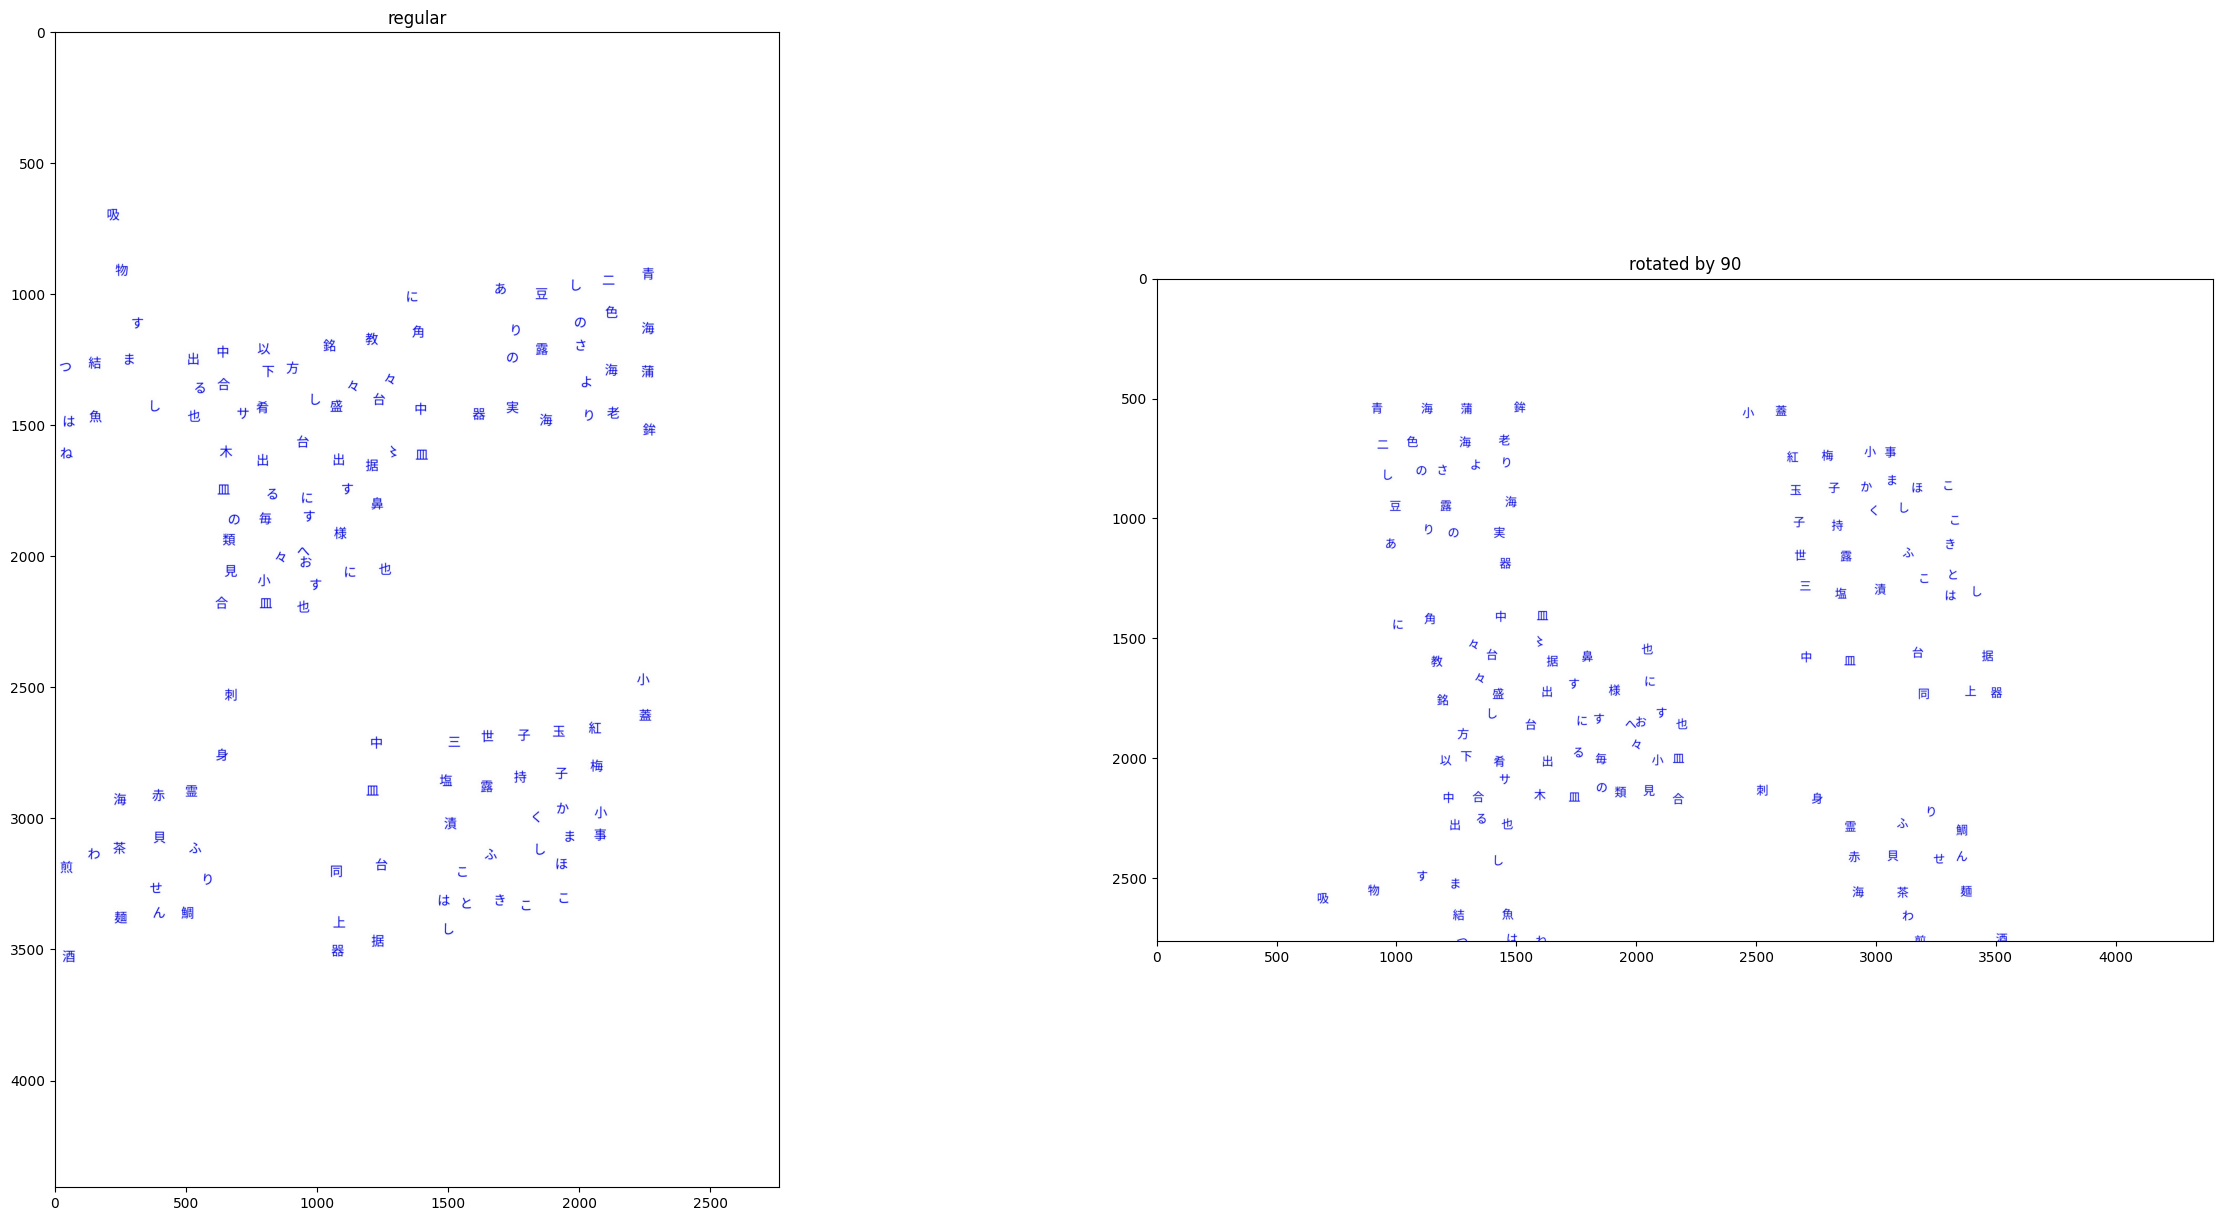

In [31]:
ocr_rot_filename = rotate_image(filename, ocr_filename)
vizualize_ocrs(ocr_filename, ocr_rot_filename)

In [32]:
result = easyocr_prediction(ocr_rot_filename, detail=1)
s = []
for x in result:
    s.append(x[1])
''.join(s)

'青  海澤 蒲鉾蓋二色海老より紅澤梅小事の さし子莉か ま ほこ豆露海三く し持あ実ふ器こ とはし中皿也中皿掘教々に盛出す  様同上 器銘しにすへお々以出小 皿サ中合木澤皿刺り出霊ふ鍋赤澤貝物海茶‥結魚わきり の蛍盛ぎに澤角き 台掘澤鼻す や台やく きヶる 毎の類 見 合身る 也せ んす   ま吸'

In [33]:
text = mangaocr_prediction(ocr_rot_filename)
print(text)

2023-10-31 01:27:04.649 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
/home/ec2-user/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2023-10-31 01:27:07.424 | INFO     | manga_ocr.ocr:__init__:19 - Using CUDA
2023-10-31 01:27:07.726 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


それでも、
